# Модель сегментации лесного массива на данных АФС

## Содержание
* [Постановка задачи](#Постановка-задачи)
* [Датасет](#Датасет)
* [Архитектура](#Архитектура)
* [Выбор гиперпараметров](#Выбор-гиперпараметров)
* [Обучение](#Обучение)
* [Инференс](#Инференс)
* [Оценка модели](#Оценка-модели)
* [Скорость работы](#Скорость-работы)
* [Критика](#Критика)
* [Краткое резюме](#Краткое-резюме)
* [Предложения по улучшению и развитию модели](#Предложения-по-улучшению-и-развитию-модели)

## Постановка задачи

По данным АФС сегментировать участки лесного массива.

In [1]:
import sys
sys.path.append('..')

from datetime import datetime

import numpy as np
from matplotlib import pyplot as plt

import tensorflow as tf

from srr.batchflow import FilesIndex, Dataset, Pipeline, F, V, B, C, R, P
from srr.batchflow.models.tf import UNet

from srr import AerialBatch
from srr.core.utils import get_origs, ce_dice_loss, make_mask, plot_img_pred_mask

%env CUDA_VISIBLE_DEVICES=7

env: CUDA_VISIBLE_DEVICES=7


## Датасет

Для построения модели используется датасет, размеченный согласно стандарту.

Датасет состоит из 81 снимка АФС в формате tif и масок к ним в формате png. Маска представляет собой одноканальное изображение, где значение каджого пикселя соответствует классу (0 - фон, 1 - лесной массив).

Классы из маски, которые будут использованы при обучении:

In [2]:
classes = (1,)

Путь к датасету:

In [3]:
path_to_data = "../ignore/GPN_AERO_FOREST/*.tif"

In [4]:
ind = FilesIndex(path=path_to_data)
ads = Dataset(ind, AerialBatch)
ads.split(0.8, shuffle=42)

Пример изображения и маски:

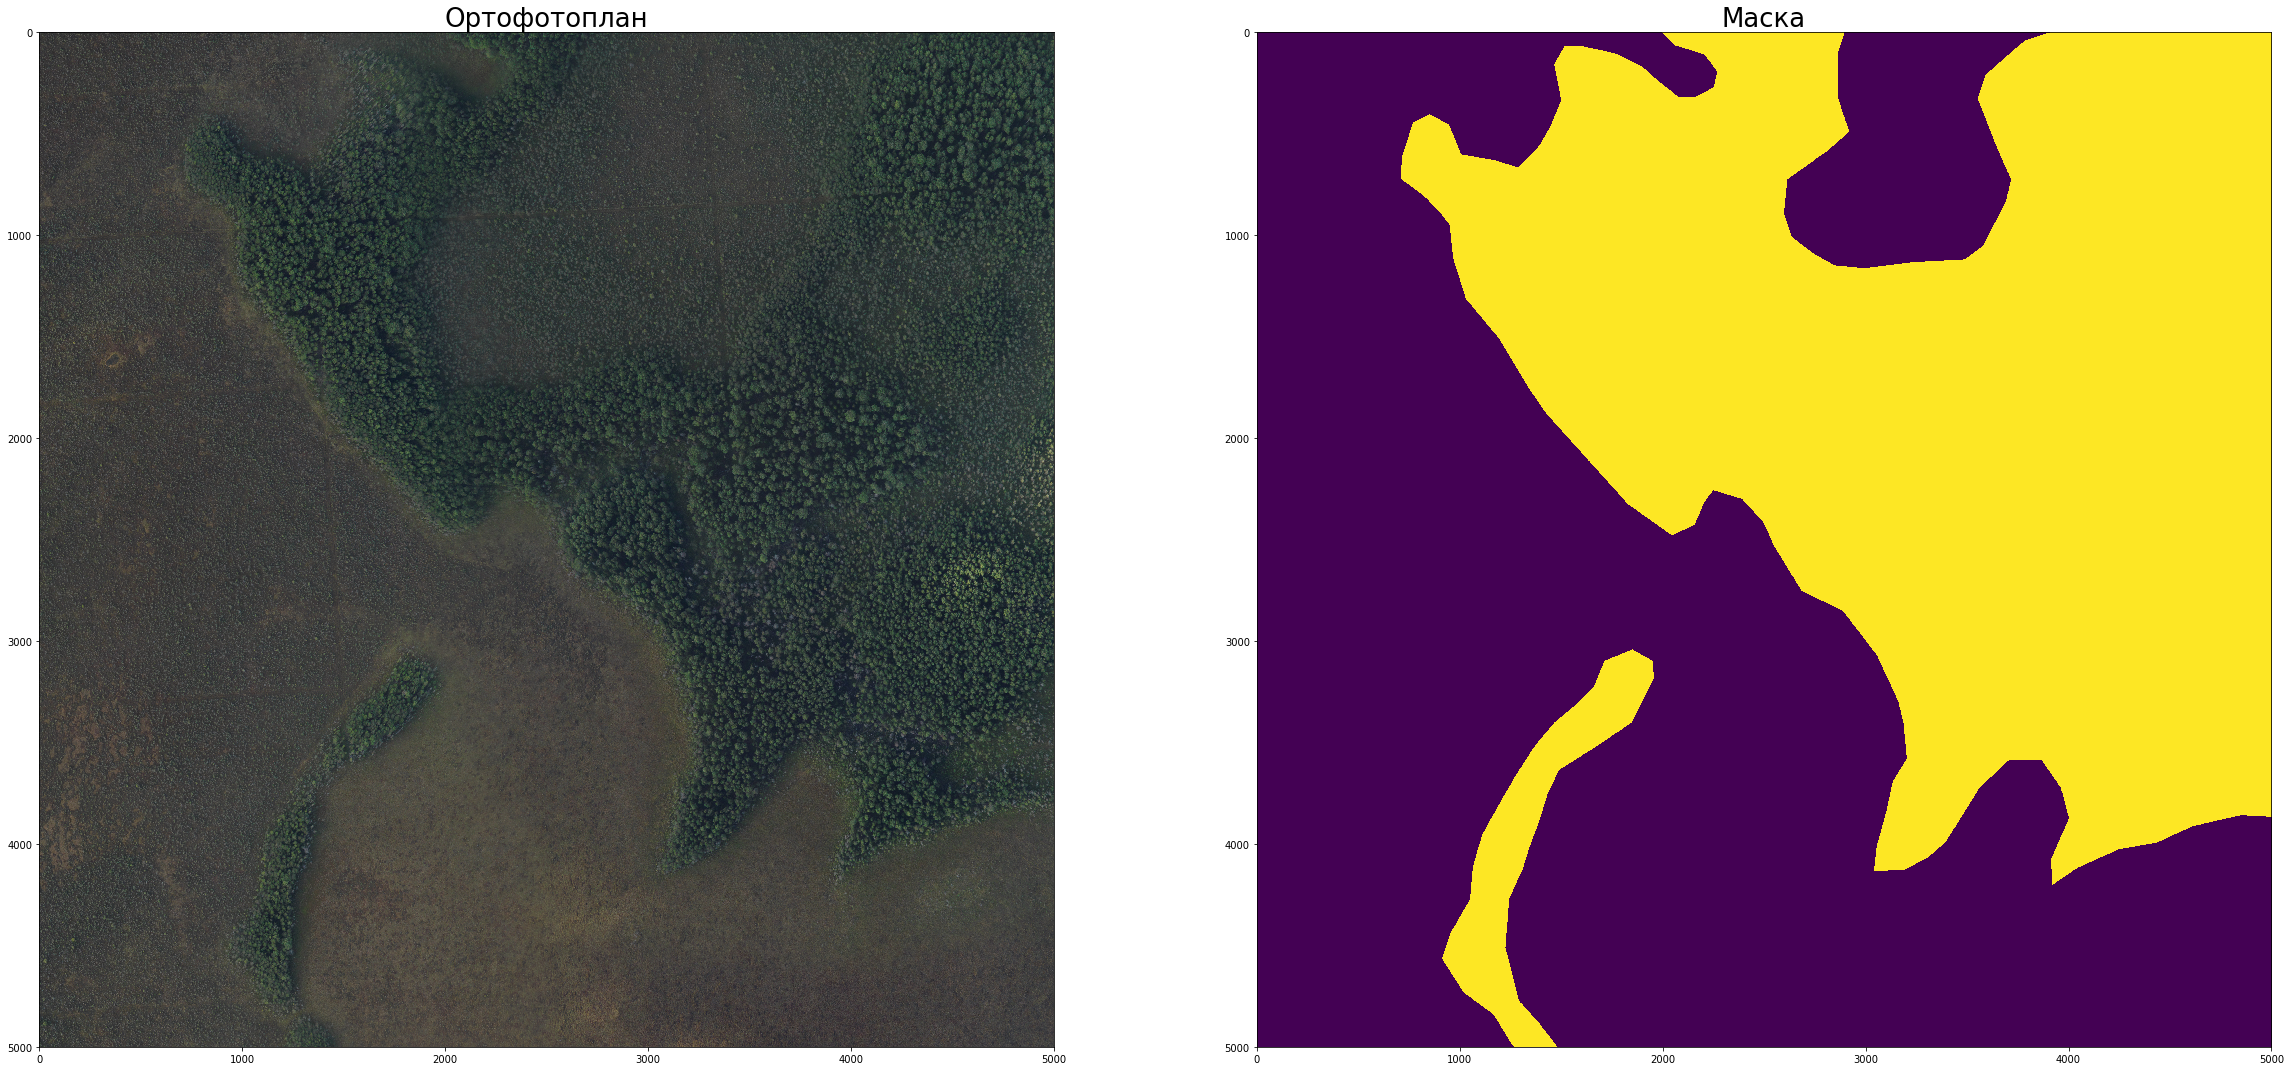

In [5]:
test_batch = ads.next_batch(1).load(ind, fmt='image', dst='images').load(ind, fmt='mask', dst='masks').to_array(src=['images', 'masks'])

f, ((ax1, ax2)) = plt.subplots(1, 2, figsize=(40, 30))
ax1.imshow(test_batch.images[0])
ax1.set_title('Ортофотоплан', fontdict={'fontsize':26})
ax2.imshow(test_batch.masks[0][:,:,0], vmin=0, vmax=1)
ax2.set_title('Маска', fontdict={'fontsize':26})
plt.show()

## Архитектура

Используется модель UNet, реализованная в библиотеке ```batchflow.models.tf```.

Размер кропов:

In [6]:
crop_shape = (256, 256)

Конфигурации модели:

In [7]:
model_config = {
    'initial_block/inputs': 'images',
    'inputs': {'images': {'shape': (256, 256, 3)},
               'masks': {'name': 'targets', 'shape': (256, 256, len(classes) + 1)}},
    'filters': [32, 64, 128],
    'head/num_classes': len(classes) + 1,
    'loss': (ce_dice_loss, {'alpha': 0.85}),
    'microbatch': 8,
    'optimizer': 'Adam',
    'body/layout': 'cnacna',
    'output': ['proba']}

## Выбор гиперпараметров

Выбор гиперпараметров, таких как: 
* архитектура модели
* количество фильтров
* количество блоков модели 

обоснован исследованиями гиперпарамтеров, представленными в файлах `./parameter_estimation_aerial.ipynb`.

## Обучение

Обучение проиcходит итерациями по батчам. Итерации состоит из:
* генерации очередной порции данных
* обновления весов нейронной сети.

Для обучения выбран оптимизатор Adam со стандартными параметрами:
* ```learning_rate``` = 0.001
* ```beta1``` = 0.9
* ```beta2``` = 0.999
* ```epsilon``` = 1e-08.

Функция потерь - взвешенная сумма `cross-entropy` и `dice`.

Схема обхода датасета:

In [8]:
batch_size = 16
n_epochs = 300

Описание пайплайна обучения:

In [9]:
train_template = (
      Pipeline()
      .load(fmt='image', dst='images')
      .load(fmt='mask', dst='masks')
      .scale(factor=P(R('uniform', 0.16, 0.24)), src=['images', 'masks'], dst=['images', 'masks'])
      .apply_transform(get_origins, crop_shape=crop_shape, classes=classes, proba=0., src='masks', dst='origs')
      .crop(shape=crop_shape, src=[('images', 'origs'), ('masks', 'origs')], dst=['images', 'masks'])
      .rotate(P(R('randint', 0, 180)), src=['images', 'masks'], dst=['images', 'masks'], p=0.5)
      .flip('lr', src=['images', 'masks'], dst=['images', 'masks'], p=0.5)
      .enhance(factor=P(R('uniform', 0.8, 1.2)))
      .to_array(src=['images', 'masks'], dst=['images', 'masks'])
      .apply_transform(make_mask, classes=classes, src='masks', dst='masks')
      .init_variable('loss', init_on_each_run=list)
      .init_model('dynamic', UNet, 'unet', model_config)
      .train_model('unet', images=B('images'), targets=B('masks'),
                   fetches='loss', save_to=V('loss', mode='a'))
).run(batch_size, shuffle=True, lazy=True)

Запуск обучения:

In [10]:
train_pipeline = (train_template << ads.train)

In [ ]:
train_pipeline.run(batch_size, n_epochs=n_epochs, bar=True, drop_last=True)

 22%|██▏       | 265/1200 [24:07<1:24:44,  5.44s/it]

График функции потерь в зависимости от числа эпох:

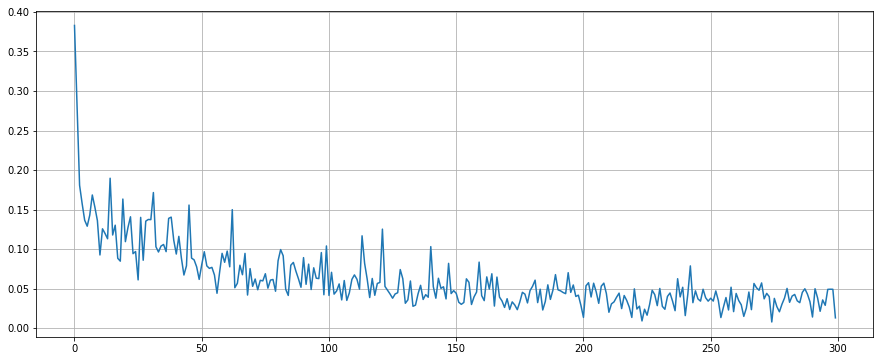

In [14]:
l = np.split(np.array(train_pipeline.get_variable('loss')), n_epochs)
f = plt.figure(figsize=(15, 6))
plt.plot(np.array(l).mean(-1))
plt.grid(True)

In [11]:
MODEL_PATH = '../ignore/models/forestation_aerial_32_64_128_cnacna_300ep/'
train_pipeline.save_model_now('unet', path=MODEL_PATH)

## Инференс

Описание процедуры прогноза:

In [12]:
load_model_config = {
    'build': False,
    'load': {'path': MODEL_PATH}
}

In [13]:
test_template = (
      Pipeline()
      .load(fmt='image', dst='images')
      .load(fmt='mask', dst='masks')
      .scale(factor=0.2, src=['images', 'masks'], dst=['images', 'masks'])
      .make_crops(shape=crop_shape, src=['images', 'masks'], dst=['images', 'masks'])
      .unstack_crops()
      .to_array(src=['images', 'masks'], dst=['images', 'masks'])
      .apply_transform(make_mask, classes=classes, src='masks', dst='masks')
      .init_variable('predictions', init_on_each_run=list)
      .init_variable('metrics', init_on_each_run=None)
      .init_variable('images', init_on_each_run=list)
      .init_variable('masks', init_on_each_run=list)
      .init_model('static', UNet, 'unet', config=load_model_config)
      .predict_model('unet', images=B('images'), fetches=['proba'], save_to=[B('predictions', mode='w')])
      .gather_metrics('segmentation', axis=-1, targets=B('masks'), predictions=B('predictions'),
                      fmt='proba', save_to=V('metrics', mode='u'))
      .update_variable('images', B('images'), mode='e')
      .update_variable('masks', B('masks'), mode='e')
      .update_variable('predictions', B('predictions'), mode='e')
).run(batch_size, n_epochs=1, lazy=True)

INFO:tensorflow:Restoring parameters from ../ignore/models/forestation_aerial_32_64_128_cnacna_300ep/model-1200


Запуск расчета метрики

In [14]:
test_pipeline = ((test_template << ads.test).run(batch_size=1, shuffle=False, 
                                                 n_epochs=1, drop_last=False, bar=True))

 94%|█████████▍| 15/16 [00:18<00:00,  1.38it/s]


## Оценка модели

Качество модели определяется средним значением метрики IOU (intersection over union) по выборке из 16 снимков.

Пример исходного изображения и предсказанной сегментации

In [15]:
predictions = test_pipeline.get_variable('predictions')
images = test_pipeline.get_variable('images')
masks = test_pipeline.get_variable('masks')

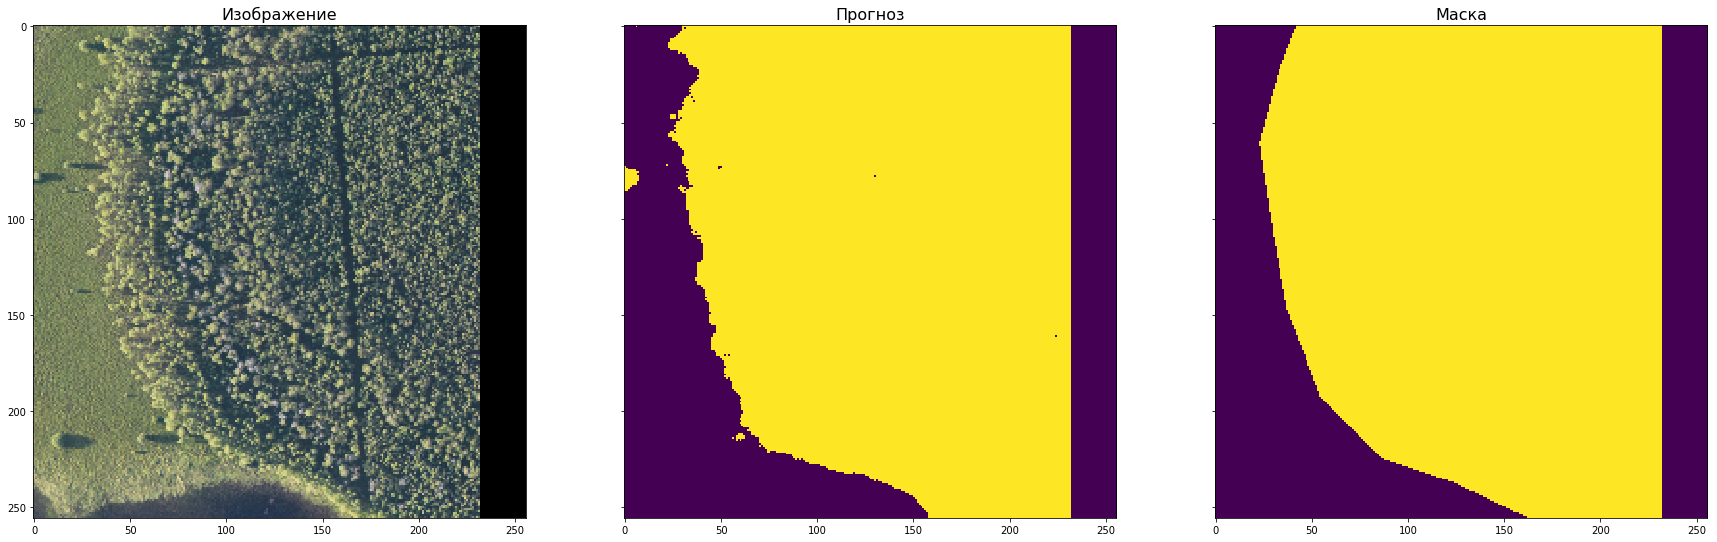

In [20]:
i = np.random.randint(len(masks))

pred = np.argmax(predictions[i][:1000, :1000], -1)
img = images[i][:1000, :1000, :]
mask = masks[i][:1000, :1000, 1]

plot_img_pred_mask(img, pred, mask)

Расчёт метрик:

In [17]:
m = test_pipeline.get_variable('metrics')
print('Метрика IoU: {:.2f}\nПопиксельная точность: {:.2f}'.format(m.evaluate('iou'), m.evaluate('accuracy')))

Метрика IoU: 0.81
Попиксельная точность: 0.95


## Скорость работы

Параметры сервера: Intel Xeon E5, NVidia GeForce 1080, 64+ Гб RAM

Одна итерация обучения на кропах размером (256, 256) пикселей при размере батча равном 16 и размере микробатча 8 занимает ~ 6 секунд.

Инференс на кропах размером (256, 256) пикселей при размере батча равном 16 (изображение размером (1000, 1000), разделенное на кропы размером (256, 256) без наложения) занимает ~ 1 секунду.

## Критика 

Модель с хорошей точностью сегментирует лесной массив; ошибки чаще всего можно наблюдать на изображениях с молодым и редким лесом.

Для построения прогнозов в реальном времени на большие участки необходимо ускорить инференс.

## Краткое резюме

Текущая модель показывает хорошую точность сегментации, при этом инференс можно ускорить за счёт процессинга изображений вне пайплайна.

## Предложения по улучшению и развитию модели

* Для улучшения качества сегментации можно при разметке выделить молодой и редкий лес в отдельные классы.

* Может быть полезным увеличить фактор масштабирования при препроцессинге, чтобы сохранять больше деталей на входном изображении для лучшего распознавания молодого и редкого леса.